In [19]:
import keras
keras.__version__

'2.2.5'

### 建立模型

In [2]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [3]:
model.summary()  

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)               

### 下载mnist数据集

In [4]:
from keras.datasets import mnist
from keras.utils import to_categorical
import numpy as np

# (train_images, train_labels), (test_images, test_labels) = mnist.load_data(path='mnist.npz')
f = np.load('mnist.npz')
train_images, train_labels = f['x_train'], f['y_train']
test_images, test_labels = f['x_test'], f['y_test']

train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [5]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=5, batch_size=64)




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/5
60000/60000 [==============================] - 9s 147us/step - loss: 0.1823 - acc: 0.9434
Epoch 2/5
60000/60000 [==============================] - 6s 105us/step - loss: 0.0465 - acc: 0.9855
Epoch 3/5
60000/60000 [==============================] - 6s 107us/step - loss: 0.0314 - acc: 0.9902
Epoch 4/5
60000/60000 [==============================] - 6s 105us/step - loss: 0.0236 - acc: 0.9930
Epoch 5/5
60000/60000 [==============================] - 6s 105us/step - loss: 0.0199 - acc: 0.9944


In [6]:
test_loss, test_acc = model.evaluate(test_images, test_labels)


10000/10000 [==============================] - 1s 74us/step


In [7]:
test_acc

0.992

### 可视化卷积输出

In [8]:
### from keras import models
from skimage import io
# Extracts the outputs of the top 5 layers:
layer_outputs = [layer.output for layer in model.layers[:5]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
img=train_images[0,:,:,0]
test_img=np.expand_dims(img,axis=0)
test_img=np.expand_dims(test_img,axis=3)
activations = activation_model.predict(test_img)

In [9]:
# first_layer_activation = activations[0]
# print(first_layer_activation.shape)
# io.imshow(test_img[0,:,:,0])

In [10]:
# import matplotlib.pyplot as plt

# io.imshow(first_layer_activation[0, :, :, 1], cmap='viridis')
# plt.show()

In [11]:
import keras
import cv2
import matplotlib.pyplot as plt
# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers[:5]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
#             channel_image -= channel_image.mean()
#             channel_image /= channel_image.std()
#             channel_image *= 64
#             channel_image += 128
#             channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    cv2.imwrite('%s.jpg'%layer_name,display_grid)
    
plt.show()


<Figure size 1600x200 with 1 Axes>

<Figure size 1600x200 with 1 Axes>

<Figure size 1600x400 with 1 Axes>

<Figure size 1600x400 with 1 Axes>

<Figure size 1600x400 with 1 Axes>

#### 给图像加一些噪声

Augmented:


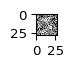

True

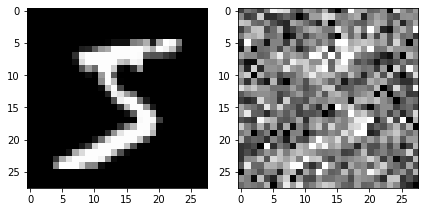

In [12]:
from imgaug import augmenters as iaa
import imgaug as ia
# ia.seed(4)
img=train_images[0,:,:,0]
#高斯噪声
rotate = iaa.AdditiveGaussianNoise(scale=0.8)
image_aug = rotate.augment_image(img)
channel_image=image_aug
channel_image -= channel_image.mean()
channel_image /= channel_image.std()
channel_image *= 64
channel_image += 128
channel_image = np.clip(channel_image, 0, 255).astype('uint8')
image_aug=channel_image
print("Augmented:")
ia.imshow(channel_image)
fig=plt.figure()
fig.add_subplot(1,2,1)
io.imshow(img)
fig.add_subplot(1,2,2)
io.imshow(channel_image)
cv2.imwrite('tmp.jpg',channel_image)

In [13]:
img=np.expand_dims(image_aug,axis=0)
img=np.expand_dims(img,axis=-1)
print(img.shape)
a=model.predict(img)

(1, 28, 28, 1)


为什么会以近乎1.0的概率将数字认错？

In [14]:
np.max(a)

1.0

In [15]:
np.argmax(a)

8

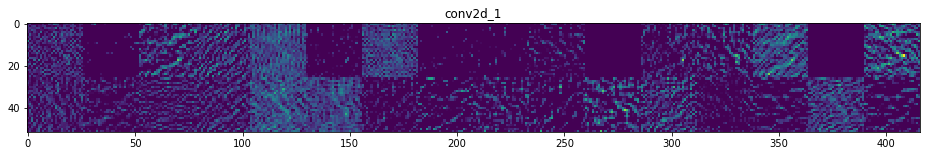

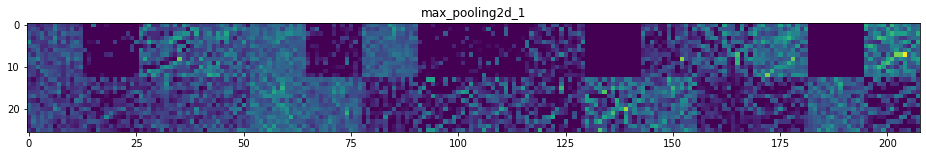

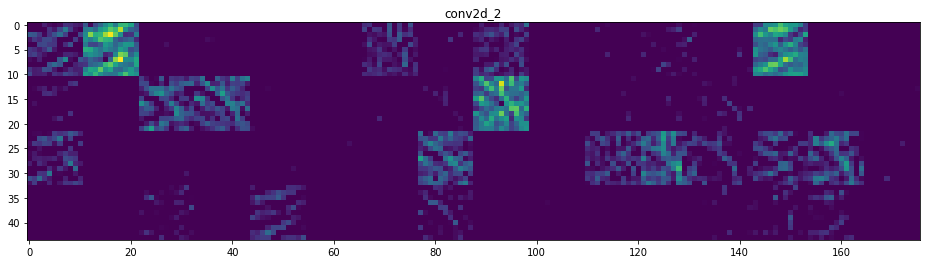

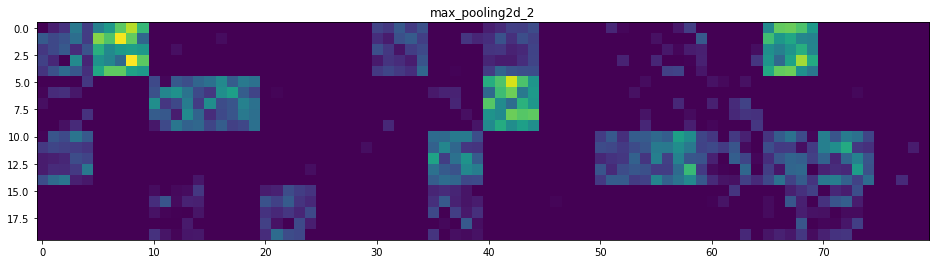

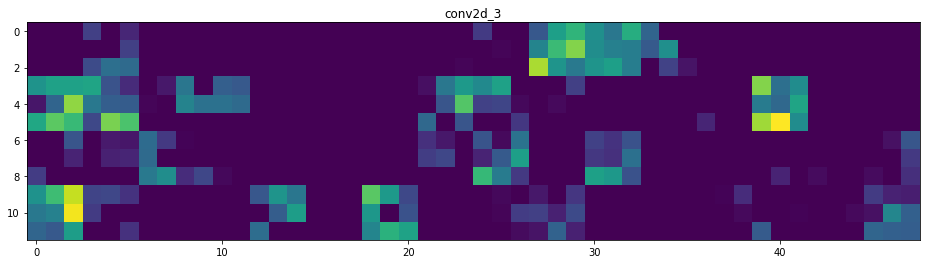

In [16]:
import keras
import cv2
activations = activation_model.predict(img)

# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers[:5]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
#             channel_image -= channel_image.mean()
#             channel_image /= channel_image.std()
#             channel_image *= 64
#             channel_image += 128
#             channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    cv2.imwrite('%s.jpg'%layer_name,display_grid)
    
plt.show()

In [17]:
import os
def predict(img_arr):
    test_img=cv2.resize(img_arr,(28,28),interpolation=cv2.INTER_AREA)
    test_img=(test_img.astype('float32')-np.min(test_img))/(np.max(test_img)-np.min(test_img))
    try:
        img=test_img[:,:,0]
    except:
        img=test_img
    img=np.expand_dims(img,axis=0)
    img=np.expand_dims(img,axis=-1)
    result=model.predict(img)
    return img,result


def show(img_dir):
    img_list=os.listdir(img_dir)
    img_list.remove('.ipynb_checkpoints')
    fig=plt.figure(figsize=(10,10))
    row=0
    col=0
    for i in range(len(img_list)):
        img_arr=io.imread(os.path.join(img_dir,'test_%d.jpg'%i))
        _,result=predict(img_arr)
        predict_label=np.argmax(result)
        confidence=np.max(result)
        fig.add_subplot(2,5,i+1)
        plt.imshow(img_arr)
        plt.title('predict:%d conf:%f'%(predict_label,confidence))

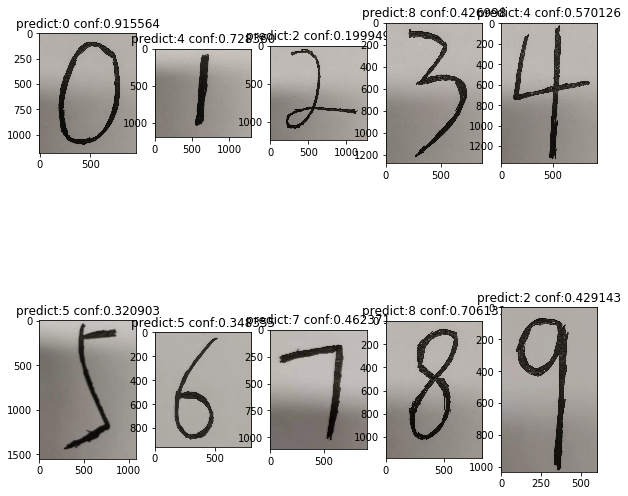

In [18]:
show('test_img')